<a href="https://colab.research.google.com/github/rutuja-patil24/CMPE-258-Deep_Learning/blob/main/Assignment_07/Part_2_04_Custom_Loss_Metric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Load and preprocess data
data = load_diabetes()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [3]:
# Custom Loss: HuberLoss
class CustomHuberLoss(keras.losses.Loss):
    def __init__(self, delta=1.0, **kwargs):
        super().__init__(**kwargs)
        self.delta = delta

    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.delta
        small_error_loss = tf.square(error) / 2
        large_error_loss = self.delta * (tf.abs(error) - self.delta / 2)
        return tf.where(is_small_error, small_error_loss, large_error_loss)

In [4]:
# Custom Metric: MeanAbsoluteError with clipping
class ClippedMAE(keras.metrics.Metric):
    def __init__(self, name="clipped_mae", **kwargs):
        super().__init__(name=name, **kwargs)
        self.total = self.add_weight(name="total", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        clipped_error = tf.clip_by_value(tf.abs(y_true - y_pred), 0, 50)
        self.total.assign_add(tf.reduce_sum(clipped_error))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))

    def result(self):
        return self.total / self.count

    def reset_states(self):
        self.total.assign(0.0)
        self.count.assign(0.0)

In [5]:
# Build model
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)
])

model.compile(
    optimizer="adam",
    loss=CustomHuberLoss(delta=10.0),
    metrics=[ClippedMAE()]
)

In [6]:
# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1
)

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - clipped_mae: 1586.9634 - loss: 1448.8785 - val_clipped_mae: 1492.5745 - val_loss: 1399.1749
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - clipped_mae: 1589.8347 - loss: 1451.4205 - val_clipped_mae: 1491.4686 - val_loss: 1391.3408
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - clipped_mae: 1586.7040 - loss: 1508.1261 - val_clipped_mae: 1489.7124 - val_loss: 1381.2030
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - clipped_mae: 1587.7937 - loss: 1400.8905 - val_clipped_mae: 1487.0762 - val_loss: 1367.7393
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - clipped_mae: 1580.4779 - loss: 1434.5193 - val_clipped_mae: 1483.5193 - val_loss: 1350.1146
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - clipped_mae: 1580.7637 - loss: 1460.6888 - val_clipped_mae: 1478.7489 - val_loss: 1327.6030
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - clipped_mae: 1563.6962 - loss: 1413.4653 - val_clipped_mae: 1471.3502 - val_

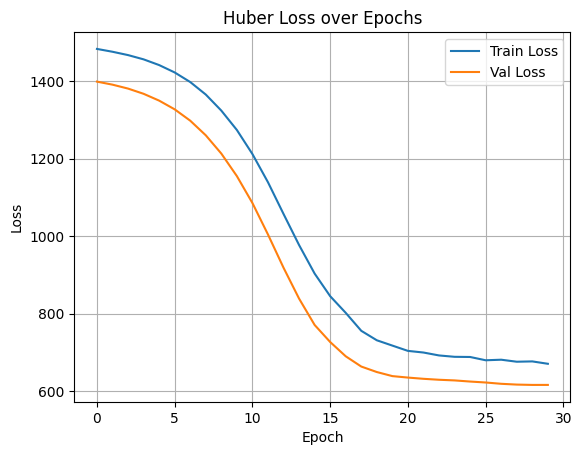

In [7]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Huber Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()